In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import numpy as np
from collections import defaultdict
from tqdm.notebook import tqdm
import torch
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output
from torch_geometric.data import Data
import torch_geometric
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch.nn import Linear
from torch_geometric.nn import MessagePassing, global_mean_pool, global_max_pool, global_add_pool
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    mean_absolute_error, mean_squared_error, r2_score
)

from sklearn.preprocessing import label_binarize

# Load and Prepare Dataset

In [2]:
from dataset import Tox21Dataset, random_split_dataset
from trainer import Trainer
import os

## Dataset with only one classification label

In [3]:
root_dir = os.path.join(os.getcwd(),'data_1')
ds = Tox21Dataset(root=root_dir, task=['NR-AhR'])

In [4]:
train_set, val_set, test_set = random_split_dataset(ds, frac_train=0.8, frac_val=0.1, frac_test=0.1, seed=0)

In [5]:
batch_size = 128

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=True)

## Define simple GAT Model and train it

In [6]:
class simpleGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout, heads=8):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=2, dropout=dropout)
        #self.conv3 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)
        self.lin1 = Linear(hidden_channels * 2, out_channels)
        #self.lin2 = Linear(8, out_channels)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        #x = self.conv3(x, edge_index).relu()
        x = global_mean_pool(x, batch)  # Aggregate node features to graph level
        #x = self.lin1(x).relu()
        return self.lin1(x)


def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out   = model(batch).flatten()
            preds.append(out.cpu())
            labels.append(batch.y.cpu())
    return torch.cat(preds), torch.cat(labels)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = simpleGAT(in_channels=train_set[0].x.size(1), hidden_channels=32,
            out_channels=train_set[0].y.size(0), heads=4, dropout=0.0).to(device)

trainer = Trainer(model=model,
                     train_loader=train_dataloader,
                     val_loader=val_dataloader,
                     test_loader=test_dataloader,
                     device=device,
                     save_dir=os.path.join(os.getcwd(),'model_saves'),
                     save_name='GAT_1')

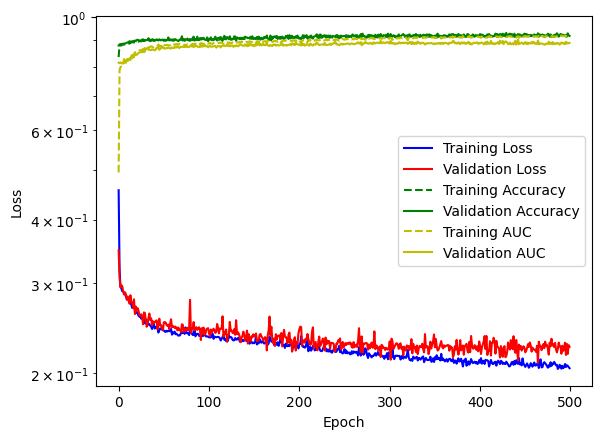

Epoch:0, Training_loss:0.4572, Training_acc:0.8350, Training_auc:0.4954, Eval_loss:0.3485, Eval_acc:0.8797, Eval_auc:0.8141
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2627, Training_acc:0.8943, Training_auc:0.8534, Eval_loss:0.2645, Eval_acc:0.9016, Eval_auc:0.8437
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:40, Training_loss:0.2447, Training_acc:0.9012, Training_auc:0.8769, Eval_loss:0.2523, Eval_acc:0.9016, Eval_auc:0.8604
saving best...
saving best...
saving best...
Epoch:60, Training_loss:0.2404, Training_acc:0.9039, Training_auc:0.8826, Eval_loss:0.2474, Eval_acc:0.9000, Eval_auc:0.8701
saving best...
saving best...
Epoch:80, Training_loss:0.2435, Training_acc:0.9018, Training_auc:0.8814, Eval_loss:0.2400, Eval_acc:0.9031, Eval_auc:0.8792
saving best...
Epoch:100, Training_loss:0.2351, Training_acc:0.9064, Training_auc:0.8887, Eval_loss:0.2392, Eval_acc:0.90

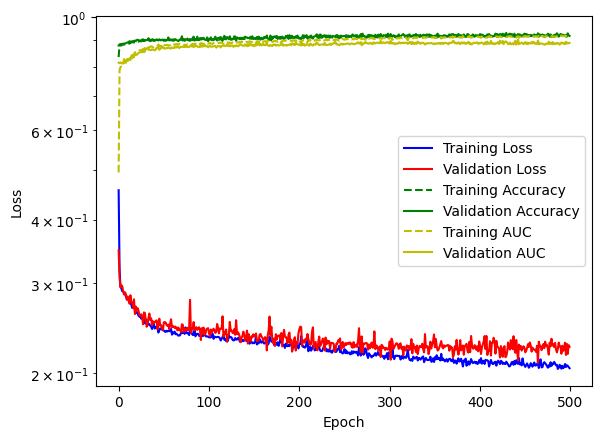

In [8]:
train_params = {'num_epochs': 500,
                'num_early_stop': 0,
                'milestones': None,
                'gamma': None}

optimizer_params = {'lr': 0.001,
                    'weight_decay': 5e-4}
                    #'momentum': 0.9}

trainer.train(train_params=train_params, optimizer_params=optimizer_params)

Test loss: 0.2643, test acc 0.8969, test_auc 0.8802


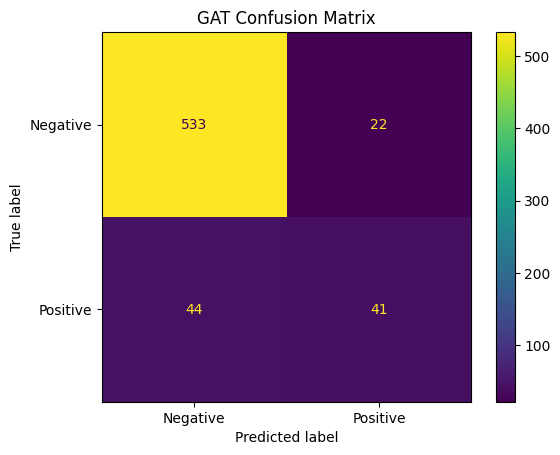

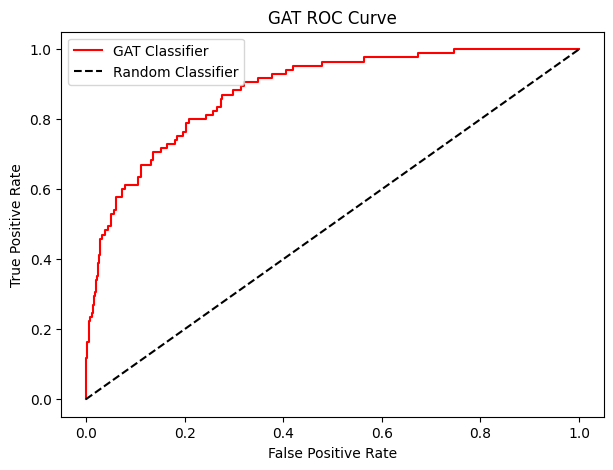

In [9]:
test_loss, test_acc, test_auc, preds, pred_probs, labels = trainer.test()

# Confusion matrix
c_matrix = confusion_matrix(labels.numpy(), preds)
disp = ConfusionMatrixDisplay(
    c_matrix, display_labels=["Negative","Positive"]
)
disp.plot() 
plt.title("GAT Confusion Matrix") 
plt.savefig('GAT_confusion.pdf')
plt.show()

# AUC by class
y_true_bin = label_binarize(labels.numpy(), classes=np.arange(2))
plt.figure(figsize=(7,5))
fpr, tpr, _ = roc_curve(y_true_bin[:, 0], pred_probs.numpy())
plt.plot(fpr, tpr, "r-", label="GAT Classifier")
plt.plot([0,1], [0,1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate")
plt.title("GAT ROC Curve") 
plt.legend() 
plt.savefig('GAT_ROC.pdf')
plt.show()